In [1]:
import pandas as pd
import pandas_profiling as ppf
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
from datetime import datetime 
import numpy as np
import os, random, math, time
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

#score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn.model_selection import cross_val_score

#modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.evaluate import PredefinedHoldoutSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz



# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
def read_file(filename):
    df = pd.read_csv(f'{filename}', encoding="utf-8") #"cp949"
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def read_file2(filename):
    df = pd.read_excel(f'{filename}', header=None)
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

In [3]:
survey_data = read_file('../Data/surveydata_md2.csv')

...There are no duplicates
shape: (160, 103)


In [4]:
survey_data.isnull().sum().any()

False

# 1. 추가 전처리

아침식전_복용 ~ 취침전_복용의 경우 약_복용알람으로 합치자.

In [5]:
survey_data['약_복용알람'] = survey_data['아침식전_복용'] + survey_data['아침식후_복용'] + survey_data['점심식전_복용'] + survey_data['점심식후_복용'] + survey_data['저녁식전_복용'] + survey_data['저녁식후_복용'] + survey_data['취침전_복용']

필요한 컬럼 선정

In [6]:
regression_data = survey_data[['sex', '종교', '기상', '아침', '점심', '저녁', '취침',
                              '약_복용알람', '환기', '산책', '당뇨', '고지혈',
                              '고혈압', '수급여부', '제공서비스','age',
                               '치매', '우울증', '만성복약', '고립', '거동불편', '소리반응', '인형관심',
                               '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀수',
                               '청결', '식사', '공공방문', 'doll_score',
                              '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
                               '신경과수면제_약', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
                               'human_detection', 'gymnastics', 'brain_timer', 'drug_consume','drug_consume_rt',
                               'psy_before','psy_after']]

In [7]:
regression_data = pd.get_dummies(data = regression_data, drop_first = True)

In [8]:
regression_data.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '환기', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '만성복약', '고립', '거동불편', '소리반응', '인형관심',
       '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀수', '식사', '공공방문',
       'doll_score', '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
       '신경과수면제_약', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
       'human_detection', 'gymnastics', 'brain_timer', 'drug_consume',
       'drug_consume_rt', 'psy_before', 'psy_after', 'sex_여', '종교_무교', '종교_불교',
       '종교_천주교', '수급여부_차상위', '청결_중', '청결_하'],
      dtype='object')

column 추가 제거: 기준은 Feature Selection ipynb에 있음

In [9]:
regression_data.drop(['환기', '만성복약', '소리반응', '인형관심', '모니터링', '배우자'], axis = 1, inplace = True)

약을 먹는데 병에 반영이 안 된 사람들 반영

In [10]:
regression_data.loc[:,'당뇨'][(regression_data['당뇨']==0) & (regression_data['당뇨_약']==1)] = 1
regression_data.loc[:,'우울증'][(regression_data['우울증']==0) & (regression_data['우울증_약']==1)] = 1
regression_data.loc[:,'고지혈'][(regression_data['고지혈']==0) & (regression_data['고지혈증_약']==1)] = 1
regression_data.loc[:,'치매'][(regression_data['치매']==0) & (regression_data['치매_약']==1)] = 1

약 지우기

In [11]:
regression_data.drop(['치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약', '신경과수면제_약'], axis = 1, inplace = True)

종교 지우기

In [12]:
regression_data.drop(['종교_불교', '종교_천주교'], axis = 1, inplace = True)

## Train/Test Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
#긍정변화 여부
Y3 = survey_data['slife_change']>0
Y3.replace([True, False], [1,0], inplace = True)

In [15]:
X = regression_data

In [16]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 123, stratify = Y3)

In [17]:
X_train['고립'].value_counts()

0    115
1     13
Name: 고립, dtype: int64

In [18]:
X_train['건강관심'].value_counts()

0    118
1     10
Name: 건강관심, dtype: int64

In [19]:
X_train['청결_하'].value_counts()

0    109
1     19
Name: 청결_하, dtype: int64

### *Numeric Data Scaling

기상, 아침, 점심, 저녁, 취침, 약 복용알람, age, 자녀수, doll_score, med_count, stroke, hand_hold_sum, knock, human_detection, gymnastics, brain_timer, drug_consume, psy_before, psy_after

In [20]:
numeric_columns = ['기상', '아침', '점심', '저녁', '취침', '약_복용알람', 'age', '자녀수', 'doll_score', 'med_count', 'stroke',
                   'hand_hold_sum', 'knock', 'human_detection', 'gymnastics', 'brain_timer', 'drug_consume','psy_before', 'psy_after']

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
min_max_scaler = MinMaxScaler()

#train, test scaling
X_train[numeric_columns] = min_max_scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = min_max_scaler.transform(X_test[numeric_columns])

### Y data split

In [23]:
#원점수
Y1 = survey_data.loc[:,'slife_after']
Y1_train = survey_data.loc[list(X_train.index.values), 'slife_after']
Y1_test = survey_data.loc[list(X_test.index.values), 'slife_after']

#변화점수
Y2 = survey_data.loc[:, 'slife_change']
Y2_train = survey_data.loc[list(X_train.index.values), 'slife_change']
Y2_test = survey_data.loc[list(X_test.index.values), 'slife_change']

#긍정변화여부
Y3_train = Y3[list(X_train.index.values)]
Y3_test = Y3[list(X_test.index.values)]

## High Correlation 제거

In [24]:
for i, c1 in enumerate (X_train.columns):
    for j, c2 in enumerate (X_train.columns):
        if (i> j )& (abs(X_train.corr().iloc[i,j])>=0.7):
            print(c1," + ",c2, ' : ', np.round(X_train.corr().iloc[i,j],4))

knock  +  stroke  :  0.9009
gymnastics  +  stroke  :  0.7732
gymnastics  +  knock  :  0.7602
brain_timer  +  hand_hold_sum  :  0.8528


In [25]:
X_train.drop(['hand_hold_sum','knock','stroke'], axis = 1, inplace = True)

In [26]:
X = X[X_train.columns]
X_test = X_test[X_train.columns]

In [27]:
for i, c1 in enumerate (X_train.columns):
    for j, c2 in enumerate (X_train.columns):
        if (i> j )& (abs(X_train.corr().iloc[i,j])>=0.7):
            print(c1," + ",c2, ' : ', np.round(X_train.corr().iloc[i,j],4))

# 1. 생활관리 원점수

## 1-1. Linear Regression

In [28]:
import statsmodels.api as sm
X_Sm= sm.add_constant(X_train)
ls=sm.OLS(Y1_train,X_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:            slife_after   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     2.103
Date:                Wed, 17 Nov 2021   Prob (F-statistic):            0.00241
Time:                        23:31:20   Log-Likelihood:                -270.52
No. Observations:                 128   AIC:                             615.0
Df Residuals:                      91   BIC:                             720.6
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              23.1426      3.406     

In [29]:
X_Sm = sm.add_constant(X_train)
Y1_pred = ls.predict(X_Sm)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 2.002720750268435


In [30]:
X_Sm = sm.add_constant(X_test)
Y1_pred = ls.predict(X_Sm)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 3.398982691673968


## 1-2. Lasso CV

In [31]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [32]:
las = LassoCV()
las.fit(X_train, Y1_train)
print("Best alpha using built-in LassoCV: %f" % las.alpha_)
print("Best score using built-in LassoCV: %f" %las.score(X_train,Y1_train))
coef = pd.Series(las.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.094675
Best score using built-in LassoCV: 0.237912


In [33]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 12 variables and eliminated the other 24 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

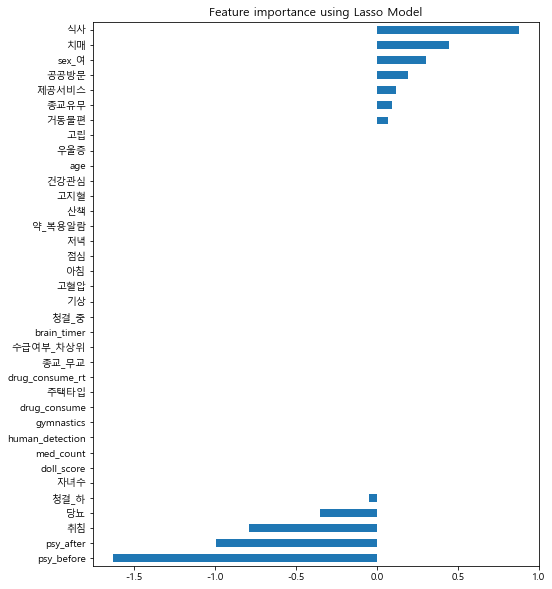

In [34]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [35]:
Y1_pred = las.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 2.3663296862231475


In [36]:
Y1_pred = las.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 2.7370182947844


## 1-3. Ridge CV

In [37]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

In [38]:
rid = RidgeCV()
rid.fit(X_train, Y1_train)
print("Best alpha using built-in RidgeCV: %f" % rid.alpha_)
print("Best score using built-in RidgeCV: %f" % rid.score(X_train,Y1_train))
coef = pd.Series(rid.coef_, index = X_train.columns)

Best alpha using built-in RidgeCV: 10.000000
Best score using built-in RidgeCV: 0.336118


Text(0.5, 1.0, 'Feature importance using Ridge Model')

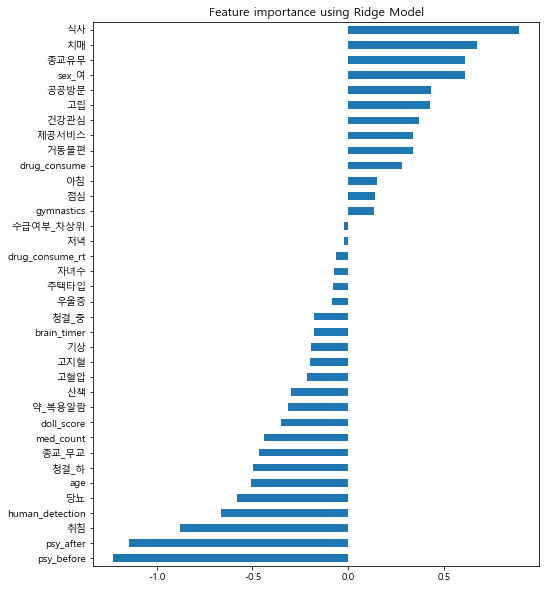

In [39]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")

In [40]:
Y1_pred = rid.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 2.2086056939976584


In [41]:
Y1_pred = rid.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 3.080272744038019


## 1-4. Linear Mixed Model

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [43]:
X_train.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '고립', '거동불편', '종교유무', '건강관심', '주택타입',
       '자녀수', '식사', '공공방문', 'doll_score', 'med_count', 'human_detection',
       'gymnastics', 'brain_timer', 'drug_consume', 'drug_consume_rt',
       'psy_before', 'psy_after', 'sex_여', '종교_무교', '수급여부_차상위', '청결_중',
       '청결_하'],
      dtype='object')

In [44]:
#doll_id 기준 group
X2 = pd.concat([X_train, survey_data['doll_id'][survey_data.index.isin(X_train.index)]], axis = 1)
X2 = pd.concat([X2, Y1_train], axis = 1)

In [45]:
#기관 기준 group
X3 = pd.concat([X_train, survey_data['기관2'][survey_data.index.isin(X_train.index)]], axis = 1)
X3 = pd.concat([X3, Y1_train], axis = 1)

In [46]:
#psy_before_cat 기준 group
X4 = pd.concat([X_train, survey_data['psy_before_cat'][survey_data.index.isin(X_train.index)]], axis = 1)
X4 = pd.concat([X4, Y1_train], axis =1)

### 1) doll_id 기준 group

In [47]:
doll_formula = 'slife_after ~ '
for i,j in enumerate(X2.drop(['doll_id','slife_after'], axis = 1).columns):
    if i==0:
        doll_formula += j
    else:
        doll_formula += '+' + j

In [48]:
doll_formula

'slife_after ~ 기상+아침+점심+저녁+취침+약_복용알람+산책+당뇨+고지혈+고혈압+제공서비스+age+치매+우울증+고립+거동불편+종교유무+건강관심+주택타입+자녀수+식사+공공방문+doll_score+med_count+human_detection+gymnastics+brain_timer+drug_consume+drug_consume_rt+psy_before+psy_after+sex_여+종교_무교+수급여부_차상위+청결_중+청결_하'

In [49]:
doll_md = smf.mixedlm(formula = doll_formula, data = X2, groups = X2['doll_id'])

In [50]:
doll_mdf = doll_md.fit()
print(doll_mdf.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: slife_after
No. Observations:   128     Method:             REML       
No. Groups:         128     Scale:              2.8208     
Min. group size:    1       Log-Likelihood:     -248.6029  
Max. group size:    1       Converged:          Yes        
Mean group size:    1.0                                    
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
Intercept       23.143    2.389  9.685 0.000  18.459 27.826
기상              -0.602    2.440 -0.247 0.805  -5.384  4.179
아침               0.752    2.170  0.346 0.729  -3.501  5.005
점심               2.206    1.248  1.767 0.077  -0.241  4.653
저녁              -0.226    1.849 -0.122 0.903  -3.850  3.399
취침              -1.243    0.676 -1.840 0.066  -2.568  0.081
약_복용알람          -0.003    1.560 -0.002 0.999  -3.06

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [51]:
doll_pred = doll_mdf.predict(X2.iloc[:,:-2])
rms = sqrt(mean_squared_error(Y1_train, doll_pred))
rms

3.194216559376347

그냥 ls 때랑 똑같네?

### 2) 기관 기준 group

In [52]:
기관_formula = 'slife_after ~ '
for i,j in enumerate(X3.drop(['기관2','slife_after'], axis = 1).columns):
    if i==0:
        기관_formula += j
    else:
        기관_formula += '+' + j

In [53]:
기관_formula

'slife_after ~ 기상+아침+점심+저녁+취침+약_복용알람+산책+당뇨+고지혈+고혈압+제공서비스+age+치매+우울증+고립+거동불편+종교유무+건강관심+주택타입+자녀수+식사+공공방문+doll_score+med_count+human_detection+gymnastics+brain_timer+drug_consume+drug_consume_rt+psy_before+psy_after+sex_여+종교_무교+수급여부_차상위+청결_중+청결_하'

In [54]:
기관_md = smf.mixedlm(formula = 기관_formula, data = X3, groups = X3['기관2'])
기관_mdf = 기관_md.fit()
print(기관_mdf.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: slife_after
No. Observations:   128     Method:             REML       
No. Groups:         7       Scale:              5.3595     
Min. group size:    2       Log-Likelihood:     -247.8752  
Max. group size:    43      Converged:          No         
Mean group size:    18.3                                   
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
Intercept       22.741    3.386  6.716 0.000  16.104 29.377
기상              -1.062    2.507 -0.424 0.672  -5.975  3.850
아침               1.611    2.527  0.638 0.524  -3.341  6.563
점심               2.470    2.318  1.066 0.287  -2.072  7.013
저녁              -0.414    2.090 -0.198 0.843  -4.510  3.681
취침              -1.200    0.671 -1.789 0.074  -2.514  0.115
약_복용알람          -0.137    1.533 -0.089 0.929  -3.14

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.631806
  warnings.warn(msg, ConvergenceWarning)


In [55]:
기관_pred = 기관_mdf.predict(X3.iloc[:,:-2])
rms = sqrt(mean_squared_error(Y1_train, 기관_pred))
rms

3.222902143984385

### 3) psy_before_cat 기준 group

In [56]:
psy_formula = 'slife_after ~ '
for i,j in enumerate(X4.drop(['psy_before_cat','slife_after'], axis = 1).columns):
    if i==0:
        psy_formula += j
    else:
        psy_formula += '+' + j

In [57]:
psy_formula

'slife_after ~ 기상+아침+점심+저녁+취침+약_복용알람+산책+당뇨+고지혈+고혈압+제공서비스+age+치매+우울증+고립+거동불편+종교유무+건강관심+주택타입+자녀수+식사+공공방문+doll_score+med_count+human_detection+gymnastics+brain_timer+drug_consume+drug_consume_rt+psy_before+psy_after+sex_여+종교_무교+수급여부_차상위+청결_중+청결_하'

In [58]:
psy_md = smf.mixedlm(formula = psy_formula, data = X4, re_formula = '~psy_before', groups = X4['psy_before_cat'])
psy_mdf = psy_md.fit()
print(psy_mdf.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    slife_after
No. Observations:    128        Method:                REML       
No. Groups:          2          Scale:                 5.6357     
Min. group size:     14         Log-Likelihood:        -248.8847  
Max. group size:     114        Converged:             Yes        
Mean group size:     64.0                                         
------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------
Intercept              23.334   11.073  2.107 0.035   1.632 45.036
기상                     -0.595    2.567 -0.232 0.817  -5.626  4.437
아침                      0.789    2.798  0.282 0.778  -4.696  6.273
점심                      2.158    2.973  0.726 0.468  -3.670  7.986
저녁                     -0.182    2.206 -0.082 0.934  -4.505  4.142
취침        

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [59]:
psy_pred = psy_mdf.predict(X4.iloc[:,:-2])
rms = sqrt(mean_squared_error(Y1_train, psy_pred))
rms

3.2128627109822903

## 1-5. SFS (Linear Regression)

### Forward

In [60]:
ols = LinearRegression()
sfs_forward = SFS(estimator=ols, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=True, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_forward.fit(X_train, Y1_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [61]:
selected_variables = list(sfs_forward.k_feature_names_)
selected_variables

['제공서비스',
 '고립',
 '종교유무',
 '주택타입',
 '식사',
 '공공방문',
 'doll_score',
 'psy_before',
 'psy_after',
 'sex_여',
 '종교_무교']

In [62]:
print('best average cv_score:',sfs_forward.k_score_)

best average cv_score: -2.3696600739846323


In [63]:
ols.fit(X_train[selected_variables], Y1_train)
Y1_pred = ols.predict(X_train[selected_variables])
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 2.2524436695434993


In [64]:
Y1_pred = ols.predict(X_test[selected_variables])
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 2.624456427083023


### Backward

In [65]:
ols = LinearRegression()
sfs_backward = SFS(estimator=ols, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=False, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_backward.fit(X_train, Y1_train)

SequentialFeatureSelector(estimator=LinearRegression(), forward=False,
                          k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [66]:
selected_variables = list(sfs_backward.k_feature_names_)
selected_variables

['취침',
 '산책',
 '당뇨',
 'age',
 '치매',
 '종교유무',
 '식사',
 'doll_score',
 'human_detection',
 'gymnastics',
 'psy_before',
 'psy_after',
 '종교_무교']

In [67]:
print('best average cv_score:',sfs_backward.k_score_)

best average cv_score: -2.39371003381196


In [68]:
ols.fit(X_train[selected_variables], Y1_train)
Y1_pred = ols.predict(X_train[selected_variables])
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 2.140974689254395


In [69]:
Y1_pred = ols.predict(X_test[selected_variables])
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 3.003120204484048


## 1-6. Decision Tree

In [70]:
randomseed = 1234

In [71]:
dtree = DecisionTreeRegressor(random_state=randomseed, min_samples_leaf=4)
dtree.fit(X_train, Y1_train)

DecisionTreeRegressor(min_samples_leaf=4, random_state=1234)

In [72]:
Y1_pred = dtree.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 1.4974805229673829


In [73]:
Y1_pred = dtree.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 3.577612701470543


## 1-7. Random Forest

In [74]:
randomseed = 1234

In [75]:
rforest = RandomForestRegressor(random_state = randomseed, min_samples_leaf=5)
rforest.fit(X_train, Y1_train)

RandomForestRegressor(min_samples_leaf=5, random_state=1234)

In [76]:
Y1_pred = rforest.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 1.6480392395248236


In [77]:
Y1_pred = rforest.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 2.626315594791285


## 1-8. XGBoost

In [78]:
randomseed = 1234

In [79]:
xgb = XGBRegressor(random_state = randomseed, max_depth = 5)
xgb.fit(X_train, Y1_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [80]:
Y1_pred = xgb.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 0.0007960282006303308


In [81]:
Y1_pred = xgb.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 3.1422368480587366


## 1-9. LGBM

In [82]:
randomseed = 1234

In [83]:
lgbm = LGBMRegressor(random_state = randomseed, max_depth = 5)
lgbm.fit(X_train, Y1_train)

LGBMRegressor(max_depth=5, random_state=1234)

In [84]:
Y1_pred = lgbm.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 1.1326766029858333


In [85]:
Y1_pred = lgbm.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 2.836864715106959


# 2. 생활관리 Change

## 2-1. Linear Regression

In [86]:
import statsmodels.api as sm
X_Sm= sm.add_constant(X_train)
ls=sm.OLS(Y2_train,X_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:           slife_change   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9973
Date:                Wed, 17 Nov 2021   Prob (F-statistic):              0.488
Time:                        23:31:43   Log-Likelihood:                -299.40
No. Observations:                 128   AIC:                             672.8
Df Residuals:                      91   BIC:                             778.3
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.6559      4.268     

In [87]:
X_Sm = sm.add_constant(X_train)
Y2_pred = ls.predict(X_Sm)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 2.509607680663442


In [88]:
X_Sm = sm.add_constant(X_test)
Y2_pred = ls.predict(X_Sm)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 3.0793677300930336


## 2-2. Lasso CV

In [89]:
las = LassoCV()
las.fit(X_train, Y2_train)
print("Best alpha using built-in LassoCV: %f" % las.alpha_)
print("Best score using built-in LassoCV: %f" %las.score(X_train,Y2_train))
coef = pd.Series(las.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.214111
Best score using built-in LassoCV: 0.000000


In [90]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 0 variables and eliminated the other 36 variables


## 2-3. Ridge CV

In [91]:
rid = RidgeCV()
rid.fit(X_train, Y2_train)
print("Best alpha using built-in RidgeCV: %f" % rid.alpha_)
print("Best score using built-in RidgeCV: %f" % rid.score(X_train,Y2_train))
coef = pd.Series(las.coef_, index = X_train.columns)

Best alpha using built-in RidgeCV: 10.000000
Best score using built-in RidgeCV: 0.203121


In [92]:
Y2_pred = rid.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.645553483566984


In [93]:
Y2_pred = rid.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.551165415369053


## 2-4. SFS (Linear Regression)

### Forward

In [94]:
ols = LinearRegression()
sfs_forward = SFS(estimator=LinearRegression(), 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=True, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_forward.fit(X_train, Y2_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [95]:
selected_variables = list(sfs_forward.k_feature_names_)
selected_variables

['산책',
 '당뇨',
 '고혈압',
 'age',
 '종교유무',
 '건강관심',
 '주택타입',
 '자녀수',
 'med_count',
 'human_detection',
 'gymnastics',
 'psy_before',
 'sex_여',
 '청결_중',
 '청결_하']

In [96]:
print('best average cv_score:',sfs_forward.k_score_)

best average cv_score: -2.824101905754083


In [97]:
ols.fit(X_train[selected_variables], Y2_train)
Y2_pred = ols.predict(X_train[selected_variables])
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.626642480678344


In [98]:
Y2_pred = ols.predict(X_test[selected_variables])
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:',rmse)

test_rmse: 3.210509622949884


### Backward

In [99]:
ols = LinearRegression()
sfs_backward = SFS(estimator=ols, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=False, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_backward.fit(X_train, Y2_train)

SequentialFeatureSelector(estimator=LinearRegression(), forward=False,
                          k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [100]:
selected_variables = list(sfs_backward.k_feature_names_)
selected_variables

['산책',
 '제공서비스',
 '종교유무',
 '건강관심',
 '주택타입',
 'human_detection',
 'gymnastics',
 '청결_중',
 '청결_하']

In [101]:
print('best average cv_score:',sfs_backward.k_score_)

best average cv_score: -2.8520825025225207


In [102]:
ols.fit(X_train[selected_variables], Y2_train)
Y2_pred = ols.predict(X_train[selected_variables])
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.742809333412982


In [103]:
Y2_pred = ols.predict(X_test[selected_variables])
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:',rmse)

test_rmse: 2.776471162967302


## 2-5. Decision Tree

In [109]:
randomseed = 1234

In [110]:
dtree = DecisionTreeRegressor(random_state=randomseed, min_samples_leaf=5)
dtree.fit(X_train, Y2_train)

DecisionTreeRegressor(min_samples_leaf=5, random_state=1234)

In [111]:
Y2_pred = dtree.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 1.854397390674308


In [112]:
Y2_pred = dtree.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 3.256368132389708


## 2-6. Random Forest

In [108]:
randomseed = 1234

In [113]:
rforest = RandomForestRegressor(random_state = randomseed, min_samples_leaf=5)
rforest.fit(X_train, Y2_train)

RandomForestRegressor(min_samples_leaf=5, random_state=1234)

In [114]:
Y2_pred = rforest.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 1.9950885752657472


In [115]:
Y2_pred = rforest.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 2.7621939010500016


## 2-7. XGBoost

In [116]:
randomseed = 1234

In [117]:
xgb = XGBRegressor(random_state = randomseed, max_depth = 5)
xgb.fit(X_train, Y2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [118]:
Y2_pred = xgb.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 0.0008186159874738921


In [119]:
Y2_pred = xgb.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 2.6870561932983796


## 2-8. LightGBM

In [120]:
randomseed = 1234

In [121]:
lgbm = LGBMRegressor(random_state = randomseed, max_depth = 5)
lgbm.fit(X_train, Y2_train)

LGBMRegressor(max_depth=5, random_state=1234)

In [122]:
Y2_pred = lgbm.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 1.418956101679446


In [123]:
Y2_pred = lgbm.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 3.4291278501512936


# 3. 긍정변화여부

## 3-1. Logistic Regression

In [125]:
X_Sm= sm.add_constant(X_train)
logit=sm.Logit(Y3_train,X_Sm).fit()
print(ls.summary())

Optimization terminated successfully.
         Current function value: 0.541929
         Iterations 8
                            OLS Regression Results                            
Dep. Variable:           slife_change   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9973
Date:                Wed, 17 Nov 2021   Prob (F-statistic):              0.488
Time:                        21:22:22   Log-Likelihood:                -299.40
No. Observations:                 128   AIC:                             672.8
Df Residuals:                      91   BIC:                             778.3
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [126]:
logit = LogisticRegression()
logit.fit(X_train, Y3_train)
Y3_pred = logit.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:',accu)

train_accuracy: 0.6796875


In [127]:
Y3_pred = logit.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.6875


## 3-2. SFS

### Forward

In [130]:
logit = LogisticRegression()
sfs_forward = SFS(estimator=logit, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=True, 
           floating=False, 
           scoring='accuracy', cv = 5)

sfs_forward.fit(X_train, Y3_train)

SequentialFeatureSelector(estimator=LogisticRegression(), k_features=(5, 15),
                          scoring='accuracy')

In [131]:
selected_variables = list(sfs_forward.k_feature_names_)
selected_variables

['산책',
 '제공서비스',
 'age',
 'doll_score',
 'human_detection',
 'gymnastics',
 'brain_timer',
 '수급여부_차상위']

In [132]:
print('best average cv_score:',sfs_forward.k_score_)

best average cv_score: 0.6575384615384616


In [133]:
logit = LogisticRegression()
logit.fit(X_train[selected_variables], Y3_train)
Y3_pred = logit.predict(X_train[selected_variables])
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:',accu)

train_accuracy: 0.65625


In [134]:
Y3_pred = logit.predict(X_test[selected_variables])
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:',accu)

test_accuracy: 0.53125


### Backward

In [135]:
logit = LogisticRegression()
sfs_backward = SFS(estimator=logit, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=False, 
           floating=False, 
           scoring='accuracy', cv = 5)

sfs_backward.fit(X_train, Y3_train)

SequentialFeatureSelector(estimator=LogisticRegression(), forward=False,
                          k_features=(5, 15), scoring='accuracy')

In [136]:
selected_variables = list(sfs_backward.k_feature_names_)
selected_variables

['기상',
 '산책',
 '고지혈',
 '제공서비스',
 'age',
 '우울증',
 '거동불편',
 '주택타입',
 '식사',
 'human_detection',
 'drug_consume',
 'sex_여',
 '수급여부_차상위',
 '청결_중',
 '청결_하']

In [137]:
print('best average cv_score:',sfs_backward.k_score_)

best average cv_score: 0.664


In [138]:
logit = LogisticRegression()
logit.fit(X_train[selected_variables], Y3_train)
Y3_pred = logit.predict(X_train[selected_variables])
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.671875


In [139]:
Y3_pred = logit.predict(X_test[selected_variables])
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.625


## 3-3. Decision Tree

In [140]:
randomseed = 333

In [141]:
#selected_variables = ['저녁', '산책', 'age', '우울증', '거동불편', '자녀수', '식사', '공공방문', 'gymnastics', 'psy_before', '수급여부_차상위']

In [142]:
dtree = DecisionTreeClassifier(random_state=randomseed, min_samples_leaf=10)
dtree.fit(X_train, Y3_train)

DecisionTreeClassifier(min_samples_leaf=10, random_state=333)

In [143]:
Y3_pred = dtree.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.734375


In [144]:
Y3_pred = dtree.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.6875


## 3-4. RandomForest

In [270]:
randomseed = 333

In [289]:
rforest = RandomForestClassifier(random_state=randomseed, min_samples_leaf=7, criterion = 'entropy')
rforest.fit(X_train, Y3_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=7,
                       random_state=333)

In [290]:
Y3_pred = rforest.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.875


In [291]:
Y3_pred = rforest.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.65625


## 3-5. XGBoost

In [352]:
randomseed = 333

In [365]:
xgb = XGBClassifier(random_state=randomseed, learning_rate = 0.01, max_depth = 5, gamma=1, base_score = 0.7)
xgb.fit(X_train, Y3_train)

[00:09:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.7, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=333,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [366]:
Y3_pred = xgb.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.828125


In [367]:
Y3_pred = xgb.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.65625


## 3-6. LGBM

In [266]:
randomseed = 1234

In [408]:
lgbm = LGBMClassifier(random_state=randomseed, learning_rate = 0.01, max_depth = 5, min_child_samples=5, num_leaves=9)
lgbm.fit(X_train, Y3_train)

LGBMClassifier(learning_rate=0.01, max_depth=5, min_child_samples=5,
               num_leaves=9, random_state=333)

In [409]:
Y3_pred = lgbm.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.9375


In [410]:
Y3_pred = lgbm.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.75
